## Instructions

Before you submit this project, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Please see the module book for full instructions on completing the project and submitting properly.

Make sure you *only* fill in places that say `your code goes here` or "YOUR ANSWER HERE". Replace the contents of those cells only, changing other cells may prevent grading. It is recommended to work in a copy and enter final answers in the submission version at the end.

When using matplotlib please make sure to use the inline option (not notebook) to allow grading: 
`%matplotlib inline`

Be aware, marks are available for following the usual good practice guidlines when creating Python code; e.g. good use of functions, efficient coding conventions, code comments etc. 

---

# MT4112 Project 1: Spectral differentiation

In this project we will consider the numerical differentiation of the following function

$$
f(x) = \cos(4\pi x)\cos(\pi x)
$$

## Q1

Define $f(x)$ and $f'(x),$ as Python functions `f(x)` and `df(x)`. Your functions should be able to operate on `numpy` arrays have one parameter and return one Python variable. **[2]**

In [1]:
# your code goes here
import numpy as np

def f(x):
    return np.cos(4*np.pi*x)*np.cos(np.pi*x)

def df(x):
    return -np.pi*(np.sin(np.pi*x)*np.cos(4*np.pi*x)+ 4*np.sin(4*np.pi*x)*np.cos(np.pi*x))






In [2]:
# Don't edit this cell

if not "f" in globals():
    raise NotImplementedError("f has not been defined in Question 1")
if not "df" in globals():
    raise NotImplementedError("df has not been defined in Question 1")


## Q2

Consider the interval $x\in[-1,1].$

Define four functions which have as parameters the number of grid points `N` and function handle `f`, and returns two arrays 
* an array of appropriate $x$ points for the method and,
* a numerical estimate of  $f'(x)$ on those points.
        
The functions/methods should be 

* `df_finite(N,f)` using second-order centered finite difference, using a differentiation matrix, on an evenly spaced **periodic** grid where $x(1)=x(-1)$.
* `df_Fourier(N,f)` using the Fourier spectral method, also on an evenly spaced periodic grid where $x(1)=x(-1)$.
* `df_Cheb1(N,f)` using the Chebyshev differentiation matrix, on the Chebyshev extremum points (code to construct the matrix can be taken from the notes).
* `df_Cheb2(N,f)` using the full Chebyshev series evaluated using the discrete cosine transform as shown in lectures, and differentiating using the `numpy` function [`cheb.chebder`](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebder.html), on the Chebyshev roots.


**[10]** (2 marks for each function and 2 marks for good practice)

In [3]:
# your code goes here
from scipy.fftpack import dct
from numpy.polynomial import chebyshev as cheb


def df_finite(N,f):

    #Setting up parameters and grid
    a = -1
    b = 1
    x1 = np.linspace(a,b,N)
    h = (b-a)/(N-1)

    #setting up the differentiation matrix using example from notes

    ik = np.arange(N)     
    matA = np.zeros((N,N))            
    matA[ik[1:N],ik[1:N]-1] = -1  
    matA[ik[1:N]-1,ik[1:N]] = 1   

    derivative = np.zeros(N)
    derivative = (1/(2*h))*(matA@f(x1))

    #boundary points
    derivative[0] = 0
    derivative[N-1] = 0

    return x1 , derivative


def df_Fourier(N,f):

    #setting up 
    x1 = np.linspace(-1,1-2/N,N)

    u = f(x1)

    #The algorithm is u -> (FFT) -> uhat -> (differentiation) -> i*k*uhat -> (IFFT) -> v

    uhat = np.fft.rfft(u)/N

    k = np.arange(0,N//2+1)*np.pi   #need to transform using k' = pi*k

    vhat = 1j*k*uhat

    v = N*np.fft.irfft(vhat)

    return x1 , v


def chebD(N): # Function from notes to obtain the Chebyshev differentiation matrix

    if N==0:
        D = 0.; x = 1.

    else:
        n = np.arange(0,N+1)
        x = np.cos(np.pi*n/N).reshape(N+1,1)
        c = (np.hstack(( [2.], np.ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
        X = np.tile(x,(1,N+1))
        dX = X - X.T
        D = np.dot(c,1./c.T)/(dX+np.eye(N+1))
        D -= np.diag(np.sum(D.T,axis=0))

    return D, x.reshape(N+1)


def df_Cheb1(N,f):

    D,x = chebD(N) #getting the differentiation matrix

    u = f(x)

    v = D@u #to obtain derivative

    return x,v


def df_Cheb2(N,f):

    
    x = np.cos(np.pi*np.arange(N)/(N-1))
    y = f(x)

    cos_series = dct(y, type=1 , n = N)/(2*N - 2) #defining cos series as shown in notes
    cos_series[1:-1] *= 2

    v = cheb.chebder(cos_series) #differentiate chebyshev series

    val = cheb.chebval(x,v) #evaluating on x points

    return x , val


    

    

In [4]:
# Don't edit this cell

if not "df_finite" in globals():
    raise NotImplementedError("df_finite has not been defined in Question 2")
if not "df_Fourier" in globals():
    raise NotImplementedError("df_Fourier has not been defined in Question 2")
if not "df_Cheb1" in globals():
    raise NotImplementedError("df_Cheb1 has not been defined in Question 2")
if not "df_Cheb2" in globals():
    raise NotImplementedError("df_Cheb2 has not been defined in Question 2")



## Q3
    
For $N\in\{2^3,2^4,..,2^{10}\}$ obtain the $L_\infty$ error between the numerical approximation and the exact $f'(x),$ plotting the four numerical approximations on the same log-log axes, taking care to label your plot. **[3]**

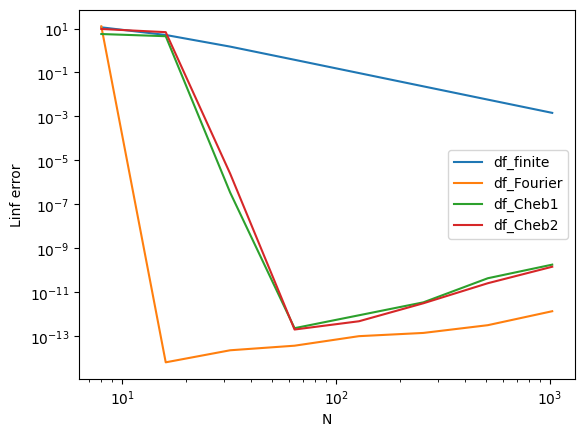

In [5]:
# your code goes here
%matplotlib inline
import matplotlib.pyplot as plt

#code for Linf error
def normInf(x):
    norm = np.max(np.abs(x))
    return norm

plt.figure()


#setting up N
N = []
for x in range(3,11):
    N.append(2**x)


for method in [df_finite,df_Fourier,df_Cheb1,df_Cheb2]:

    linf = []
    for i in N:
        
        #calculate and store linf error for given 2**k and method
        x,v = method(i,f)
        analytical = df(x)
        error = v-analytical

        linf.append(normInf(error))

    plt.loglog(N,linf,label=method.__name__)

plt.xlabel("N")
plt.ylabel("Linf error")
plt.legend();



## Q4

Time your functions with an appropriate method, taking care to account for function overhead. Plot your timing data to help answer the mutliple choice questions below. **[3]**

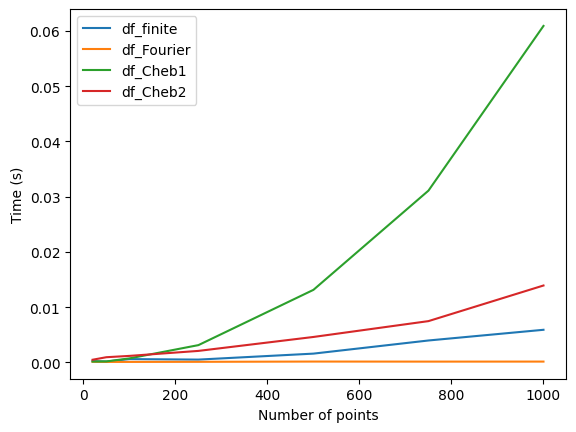

In [6]:
# your code goes here
from time import perf_counter
from statistics import mean

plt.figure()

N = [20,50,100,250,500,750,1000]

for method in [df_finite,df_Fourier,df_Cheb1,df_Cheb2]:

    time_taken = []

    for n in N:

        measurements = []

        #taking 10 measurements for given magnitude and getting the average
        for x in range(10):

            start = perf_counter()

            method(n,f)

            end = perf_counter()

            measurements.append(end-start)

        time_taken.append(mean(measurements))

    plt.plot(N,time_taken,label=method.__name__)

plt.xlabel("Number of points")
plt.ylabel("Time (s)")
plt.legend();

Determine the answers to the following questions, creating variable names `A1`, `A2`, `A3`, `A4` and `A5` setting their value to be the single character string `a`, `b`, or `c` corresponding to your answer:

### 4.1

With a large number of points, the fastest numerical differentiation method is usually **[1/2]**

**a** Fourier

**b** Finite difference

**c** Chebyshev Polynomial

**d** Chebyshev Series

### 4.2
Given a certain amount of CPU time the least accurate numerical differentiation method is usually **[1/2]**

**a** Fourier

**b** Finite difference

**c** Chebyshev Polynomial

**d** Chebyshev Series

### 4.3
Overall, in terms of efficiency, the best approach to numerically differentiate this function is **[1/2]**

**a** Fourier

**b** Finite difference

**c** Chebyshev Polynomial

**d** Chebyshev Series

### 4.4
It is appropriate to use large numbers of points for the Fourier method for this function. **[1/2]**

**a** True

**b** False

In [7]:
# your code goes here
A1 = "a"
A2 = "b"
A3 = "a"
A4 = "b"

In [8]:
# Don't edit this cell

if not "A1" in globals():
    raise NotImplementedError("A1 has not been defined in Question 4")
if not "A2" in globals():
    raise NotImplementedError("A2 has not been defined in Question 4")
if not "A3" in globals():
    raise NotImplementedError("A3 has not been defined in Question 4")
if not "A4" in globals():
    raise NotImplementedError("A4 has not been defined in Question 4")



## Q5

If we were to change the test function to 

$$
g(x) = \mathrm{sech}^2(x)
$$

which method (or methods) would be expected to perform best and why? Put your answer as a *short* free text response in the markdown cell below, you should not include any code or results. **[2]**

The derivative of g(x) is not periodic on [-1,1]. This suggests the Chebyshev methods would be a better choice than Fourier. I would not expect big differences in error between the Chebyshev methods and so given its greater speed, I would expect df_Cheb2 to perform the best.

## Q6

A fourth-order finite difference scheme can be defined as

$$
f'(x_j) \approx \frac{f_{j-2}-8f_{j-1} + 8f_{j+1} - f_{j+2}}{12h}
$$

Implement this scheme via a differentiation matrix in the same format as the function `df_finite(N,f)` now called `df_finite4(N,f)`.

Take care with the periodicity of the grid. Create a Python variable `err_FD4` for the $L_\infty$ error with $N=128$. **[3]**

In [9]:
# your code goes here
def df_finite4(N,f):

    #Setting up parameters and grid
    a = -1
    b = 1
    x1 = np.linspace(a,b,N)
    h = (b-a)/(N-1)

    #Setting up differentiation matrix
    ik = np.arange(N)     
    matA = np.zeros((N,N))

    #central diagonal is 0

    #1st lower diagonal should be -8             
    matA[ik[1:N],ik[1:N]-1] = -8

    #2nd lower diagonal should be 1
    matA[ik[2:N],ik[1:N-1]-1] = 1

    #1st upper diagonal should be 8  
    matA[ik[1:N]-1,ik[1:N]] = 8

    #2nd upper diagonal should be -1
    matA[ik[1:N-1]-1,ik[2:N]] = -1

    derivative = np.zeros(N)
    derivative = (1/(12*h))*(matA@f(x1))

    #due to the nature of the scheme, the first two and last two points will not be accurate. Here I chose to set them manually
    #using the analytical solution
    
    derivative[0:2] = df(x1[0:2])
    derivative[-1:-3:-1] = df(x1[-1:-3:-1])

    return x1 , derivative

#getting error norm

x , v = df_finite4(128,f)
error = v -df(x)
err_FD4 = normInf(error)

In [10]:
# Don't edit this cell

if not "df_finite4" in globals():
    raise NotImplementedError("df_finite4 has not been defined in Question 6")
if not "err_FD4" in globals():
    raise NotImplementedError("err_FD4 has not been defined in Question 6")

